In [3]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [4]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [5]:
### Set file names
runningLocation = 'gdata'
if  runningLocation== 'local':
    hisOSSEFilePath='../data/raw/OSSE_SSHSST/'
    hisTruthFilePath='../data/raw/truth/final/'
    obsFinalFilePath='../data/raw/OSSE_SSHSST/' #the 'final' obs files: Verification obs, + NLmodel values from modTruth.
    modOSSEFilePath='../data/raw/OSSE_SSHSST/'
    # hisPertFilePath='../data/raw/perturbed/'
elif runningLocation == 'gdata':
    hisOSSEFilePath='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
    hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings
    obsFinalFilePath='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
    modOSSEFilePath='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
#     hisPertFilePath='/g/data/fu5/deg581/EAC_2yr_perturbedRun_final/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [6]:
import glob
glob.glob(hisOSSEFilePath+'pre.*')

['/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/pre.08017',
 '/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/pre.08021',
 '/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/pre.08005',
 '/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/pre.08025',
 '/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/pre.08009',
 '/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/pre.08013']

### Load functions

In [7]:
### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [8]:
timeRange = [8005, 8029]

In [9]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

## mean metric analysis

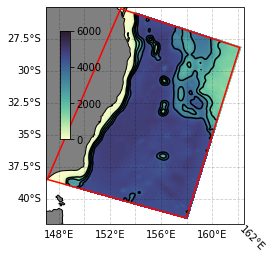

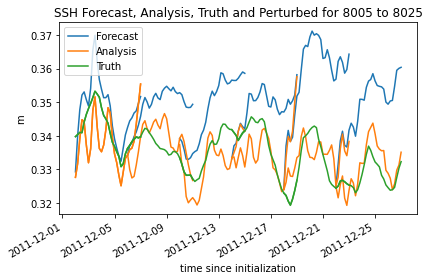

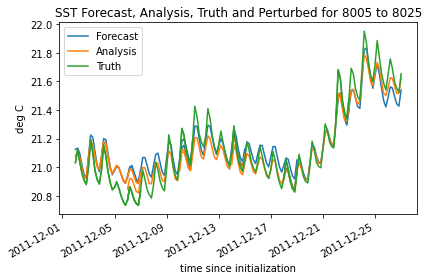

In [10]:
### Now same but for 'upstream' area

etaRangeMetric = [0, 315] #[115, 200]
xiRangeMetric = [0, 270] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    # filenamePert   =hisPertFilePath+prefixPert+'0'+str(dates)+'.nc'
    # sshPert     = xr.open_dataset(filenamePert).zeta.load()
    # sstPert     = xr.open_dataset(filenamePert).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        # sst_metricPert = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
        temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = xr.merge([sst_metricTruth, temp])
        # temp = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # sst_metricPert = xr.merge([sst_metricPert, temp])
        # temp = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = xr.merge([ssh_metricPert, temp])

fig = plt.figure()
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# ssh_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     ssh_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

fig = plt.figure()
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
sst_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# sst_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    sst_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     sst_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

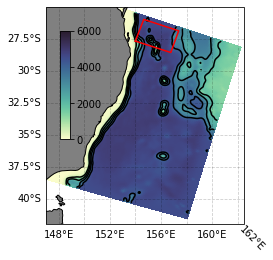

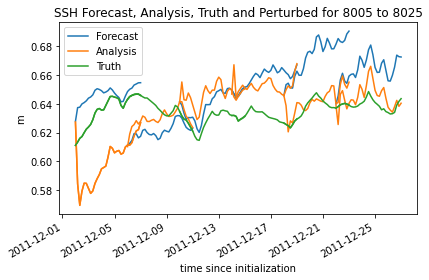

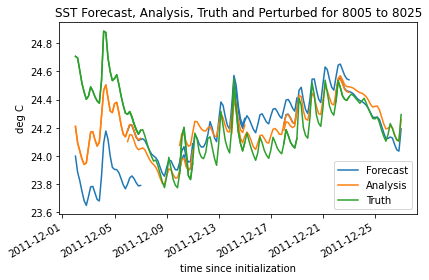

In [11]:
etaRangeMetric = [270, 310] #[115, 200]
xiRangeMetric = [75, 175] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    # filenamePert   =hisPertFilePath+prefixPert+'0'+str(dates)+'.nc'
    # sshPert     = xr.open_dataset(filenamePert).zeta.load()
    # sstPert     = xr.open_dataset(filenamePert).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        # sst_metricPert = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
        temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = xr.merge([sst_metricTruth, temp])
        # temp = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # sst_metricPert = xr.merge([sst_metricPert, temp])
        # temp = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = xr.merge([ssh_metricPert, temp])

fig = plt.figure()
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# ssh_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     ssh_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()
#plt.xlim(['2012-01-15','2012-02-15'])

fig = plt.figure()
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
sst_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# sst_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    sst_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     sst_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

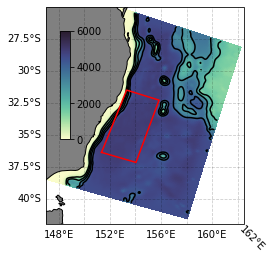

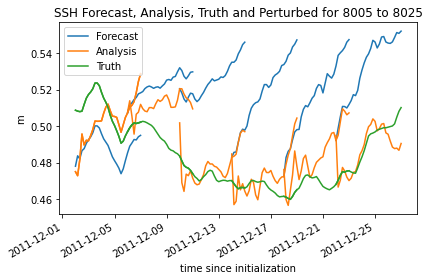

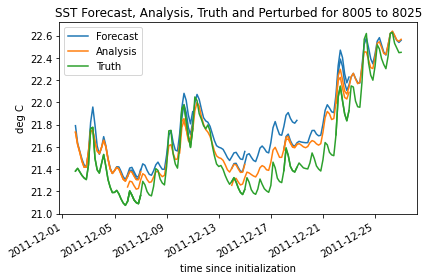

In [12]:
etaRangeMetric = [70, 185] #[115, 200]
xiRangeMetric = [105, 185] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    # filenamePert   =hisPertFilePath+prefixPert+'0'+str(dates)+'.nc'
    # sshPert     = xr.open_dataset(filenamePert).zeta.load()
    # sstPert     = xr.open_dataset(filenamePert).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        # sst_metricPert = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
        temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = xr.merge([sst_metricTruth, temp])
        # temp = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # sst_metricPert = xr.merge([sst_metricPert, temp])
        # temp = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = xr.merge([ssh_metricPert, temp])

fig = plt.figure()
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# ssh_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     ssh_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()
#plt.xlim(['2012-01-15','2012-02-15'])

fig = plt.figure()
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
sst_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# sst_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    sst_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     sst_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

## RMS overview

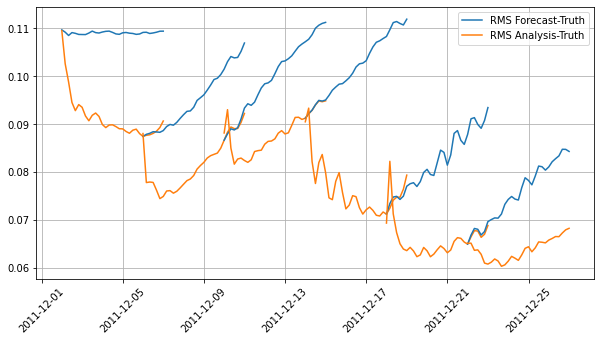

In [13]:

datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

fig, ax = plt.subplots(1,figsize=(10,5))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    Ana_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshTruth)**2,axis=2),axis=1))
    Fore_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast-sshTruth)**2,axis=2),axis=1))
    Ana_Fore = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshForecast)**2,axis=2),axis=1))
    time = sshForecast.ocean_time.values
    if dates == datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='RMS Forecast-Truth')
        ax.plot(time, Ana_Truth, color="C1",label='RMS Analysis-Truth')
    elif dates != datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='_nolegend_')
        ax.plot(time, Ana_Truth, color="C1",label='_nolegend_')
        
#     ax.plot(time, Ana_Fore, color="C2",label='Truth')
ax.legend()
ax.grid()
ax.tick_params('x',labelrotation=45)


In [14]:
timePeriod = 4  #days
timeOutputs = 1 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

rr=0
timeVec = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHobs = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHmod = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHanal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHfore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSHerror_fore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSHerror_anal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHtruth = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHfore = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHanal = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()
    
    filenameObs=obsFinalFilePath+prefixObs+str(dates)+'.nc'
    obs=xr.open_dataset(filenameObs).load()

    for tChunk in range(0,timeOutputMax,timeOutputs):
        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2)
        # print(tChunk,time1,time2,time1sd,time2sd)
        timeVec[rr]=np.nanmean([time1sd,time2sd])

        modVal = mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        obsVal = obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        modAnal = mod.NLmodel_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        modFore = mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        meanSSHobs[rr] = np.nanmean(obsVal)
        meanSSHmod[rr] = np.nanmean(obsVal)
        meanSSHanal_obsspace[rr] = np.nanmean(modAnal)
        meanSSHfore_obsspace[rr] = np.nanmean(modFore)
        rmsSSHerror_fore_obsspace[rr] = np.sqrt(((modFore - obsVal)**2).mean(dim='datum',skipna=True))
        rmsSSHerror_anal_obsspace[rr] = np.sqrt(((modAnal - obsVal)**2).mean(dim='datum',skipna=True))

        meanSSHtruth[rr] = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSHfore[rr]  = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSHanal[rr]  = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)

        rr=rr+1




/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/ipykernel_launcher.py:

(0.2, 0.5)

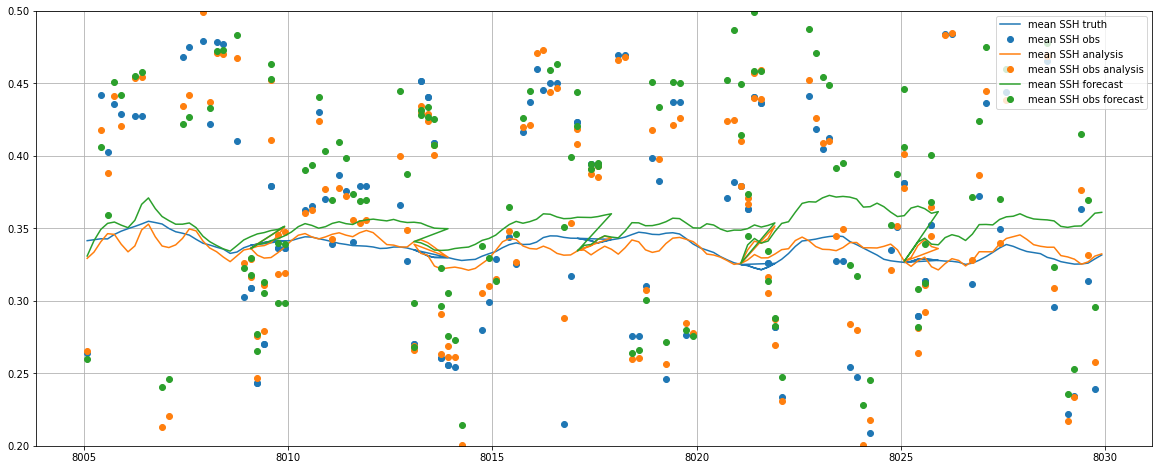

In [15]:

fig,ax = plt.subplots(1,figsize=(20,8))
ax.plot(timeVec,meanSSHtruth,linestyle='-',color="C0",label='mean SSH truth')
ax.plot(timeVec,meanSSHobs,linestyle='none',marker='o',color="C0",label='mean SSH obs')
ax.plot(timeVec,meanSSHanal,linestyle='-',color="C1",label='mean SSH analysis')
ax.plot(timeVec,meanSSHanal_obsspace,linestyle='none',marker='o',color="C1",label='mean SSH obs analysis')
ax.plot(timeVec,meanSSHfore,linestyle='-',color="C2",label='mean SSH forecast')
ax.plot(timeVec,meanSSHfore_obsspace,linestyle='none',marker='o',color="C2",label='mean SSH obs forecast')
ax.grid()
ax.legend()
ax.set_ylim([.2,.5])

Text(0.5, 1.0, 'mean SSH for truth and analysis')

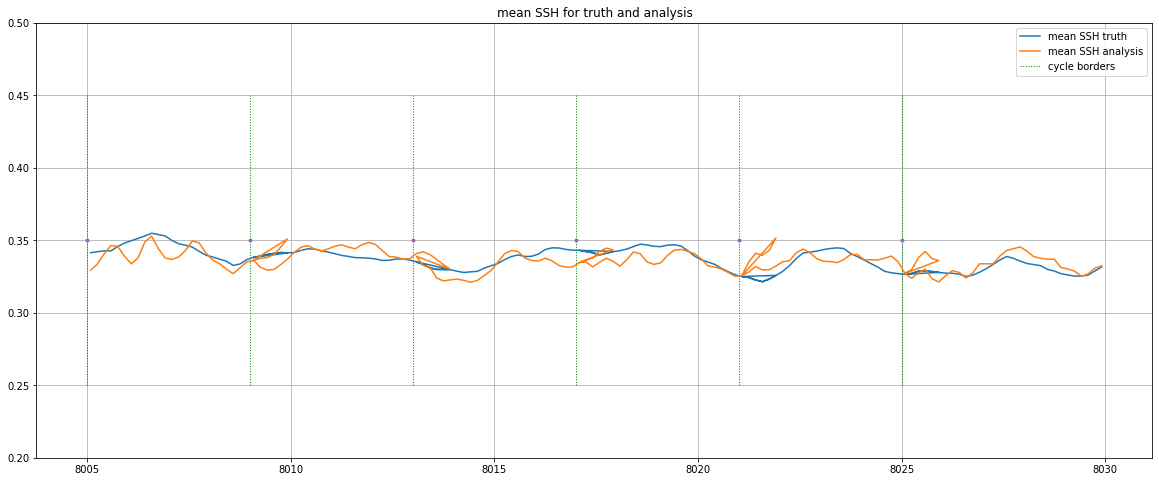

In [16]:

fig,ax = plt.subplots(1,figsize=(20,8))
ax.plot(timeVec,meanSSHtruth,linestyle='-',color="C0",label='mean SSH truth')
ax.plot(timeVec,meanSSHanal,linestyle='-',color="C1",label='mean SSH analysis')
ax.plot(datelist,np.array(0.35*np.ones([len(datelist),1])),color='C4',linestyle='none',marker='o',markersize=3)
ax.vlines(datelist, ymin=0.25, ymax=.45, colors='green', ls=':', lw=1, label='cycle borders')
ax.grid()
ax.legend()
ax.set_ylim([.2,.5])
# ax.set_xlim([8080,8120])
ax.set_title('mean SSH for truth and analysis')

(15385.0, 15425.0)

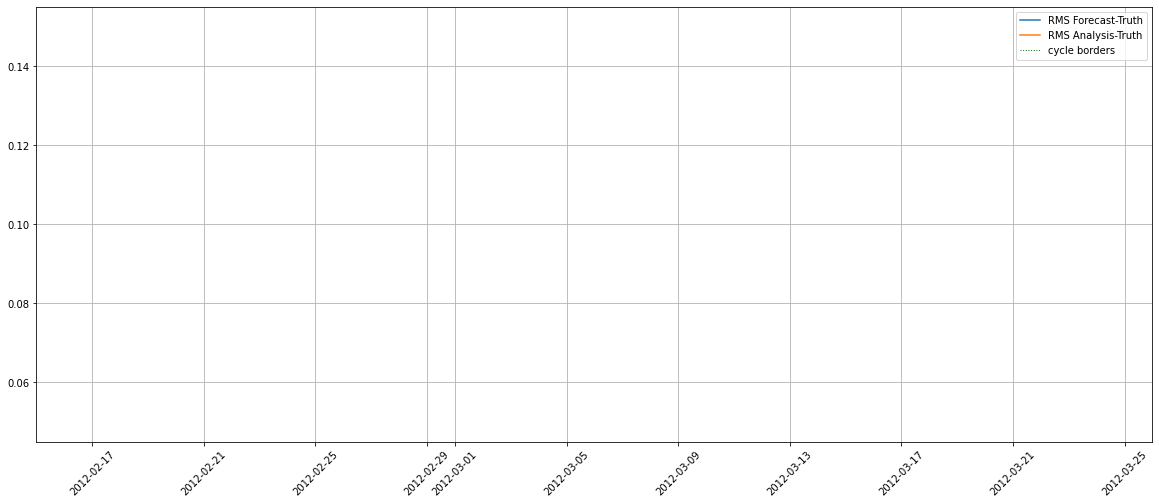

In [17]:

fig, ax = plt.subplots(1,figsize=(20,8))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    Ana_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshTruth)**2,axis=2),axis=1))
    Fore_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast-sshTruth)**2,axis=2),axis=1))
    Ana_Fore = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshForecast)**2,axis=2),axis=1))
    time = sshForecast.ocean_time.values
    if dates == datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='RMS Forecast-Truth')
        ax.plot(time, Ana_Truth, color="C1",label='RMS Analysis-Truth')
        ax.vlines(time[0], ymin=0.05, ymax=.15, colors='green', ls=':', lw=1, label='cycle borders')
    elif dates != datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='_nolegend_')
        ax.plot(time, Ana_Truth, color="C1",label='_nolegend_')
        ax.vlines(time[0], ymin=0.05, ymax=.15, colors='green', ls=':', lw=1, label='_nolegend_')

ax.legend()
ax.grid()
ax.tick_params('x',labelrotation=45)
ax.set_xlim([serial_day_to_datestring(8080),serial_day_to_datestring(8120)])

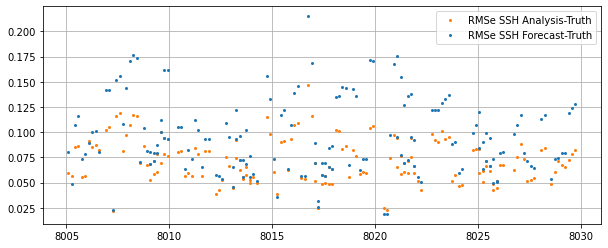

In [18]:

fig,ax = plt.subplots(1,figsize=(10,4))
ax.plot(timeVec,rmsSSHerror_anal_obsspace,linestyle='none',marker='o',color="C1",label='RMSe SSH Analysis-Truth',markersize=2)
ax.plot(timeVec,rmsSSHerror_fore_obsspace,linestyle='none',marker='o',color="C0",label='RMSe SSH Forecast-Truth',markersize=2)
ax.grid()
ax.legend()


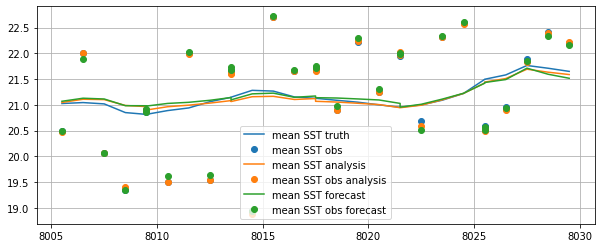

In [19]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=340

rr=0
timeVec = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTobs = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTmod = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTanal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTfore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSTerror_fore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSTerror_anal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTtruth = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTfore = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTanal = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()
    
    filenameObs=obsFinalFilePath+prefixObs+str(dates)+'.nc'
    obs=xr.open_dataset(filenameObs).load()

    for tChunk in range(0,timeOutputMax,timeOutputs):
        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2)
        # print(tChunk,time1,time2,time1sd,time2sd)
        timeVec[rr]=np.nanmean([time1sd,time2sd])

        modVal = mod.obs_value.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        obsVal = obs.obs_value.where(np.isnan(mod.obs_scale)==False).where((obs.obs_provenance==provValue) & (obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        modAnal = mod.NLmodel_value.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        modFore = mod.NLmodel_initial.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        meanSSTobs[rr] = np.nanmean(obsVal)
        meanSSTmod[rr] = np.nanmean(obsVal)
        meanSSTanal_obsspace[rr] = np.nanmean(modAnal)
        meanSSTfore_obsspace[rr] = np.nanmean(modFore)
        rmsSSTerror_fore_obsspace[rr] = np.sqrt(((modFore - obsVal)**2).mean(dim='datum',skipna=True))
        rmsSSTerror_anal_obsspace[rr] = np.sqrt(((modAnal - obsVal)**2).mean(dim='datum',skipna=True))

        meanSSTtruth[rr] = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSTfore[rr]  = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSTanal[rr]  = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)

        rr=rr+1




fig,ax = plt.subplots(1,figsize=(10,4))
ax.plot(timeVec,meanSSTtruth,linestyle='-',color="C0",label='mean SST truth')
ax.plot(timeVec,meanSSTobs,linestyle='none',marker='o',color="C0",label='mean SST obs')
ax.plot(timeVec,meanSSTanal,linestyle='-',color="C1",label='mean SST analysis')
ax.plot(timeVec,meanSSTanal_obsspace,linestyle='none',marker='o',color="C1",label='mean SST obs analysis')
ax.plot(timeVec,meanSSTfore,linestyle='-',color="C2",label='mean SST forecast')
ax.plot(timeVec,meanSSTfore_obsspace,linestyle='none',marker='o',color="C2",label='mean SST obs forecast')
ax.grid()
ax.legend()
# ax.set_ylim([.2,.5])

## now plot snapshots of fields

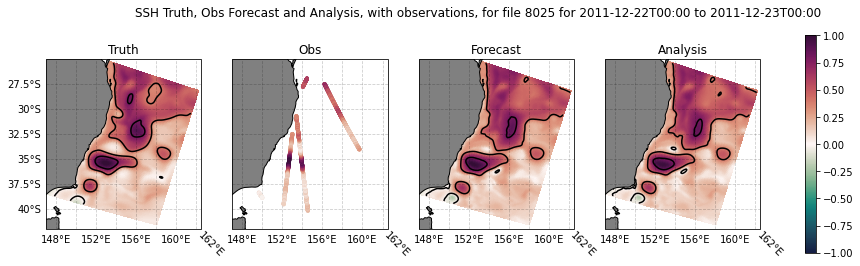

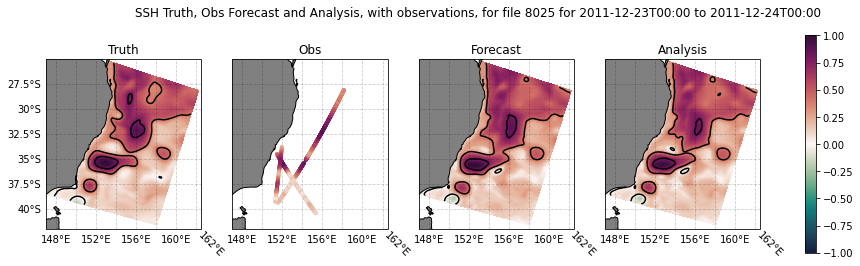

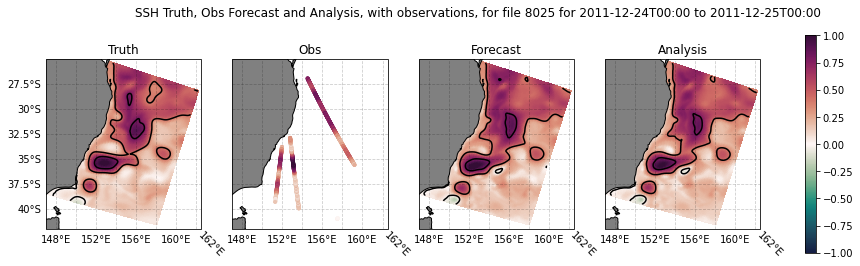

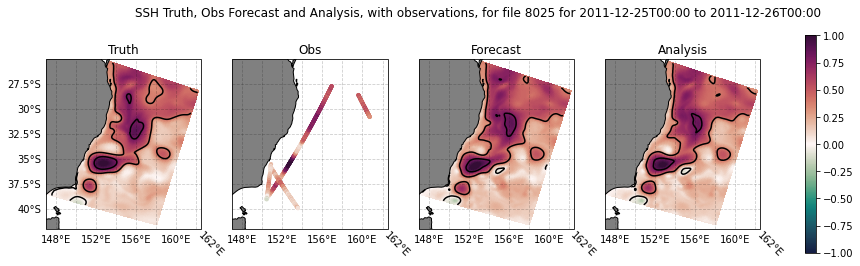

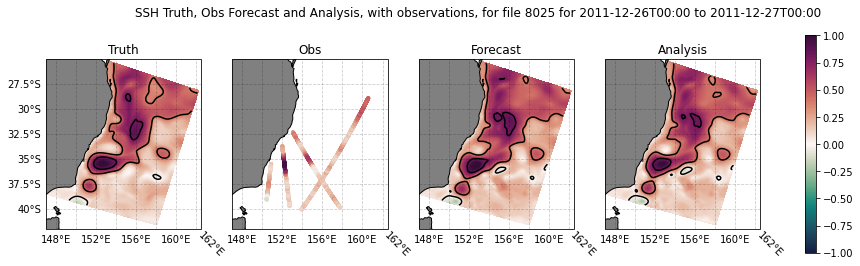

In [20]:
timePeriod = 4  #days
timeOutputs = 6 # 4hrlymodel output * timeOutputs = hrs per snapshot. e.g. 3(*4hrs)=12hrly outputs, 6=24hrly output
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8033] 
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=405

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    
    for tChunk in range(0,timeOutputMax,timeOutputs):
        fig, axes = plt.subplots(1,4, figsize=(16, 4), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        toPlotData = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[0]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([-1,1])
        ax.set_title('Truth')
        
        ax = axes[1]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        ax.set_title('Obs')
        
        toPlotData = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[2]            
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        im.set_clim([-1,1])
        ax.set_title('Forecast')


        toPlotData = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[3]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False  
        gl.left_labels = False
        im.set_clim([-1,1])
        ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        fig.colorbar(im, ax=axes.ravel().tolist())
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SSH Truth, Obs Forecast and Analysis, with observations, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('m')




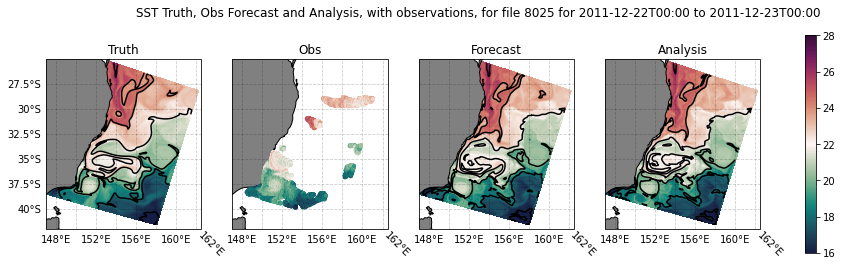

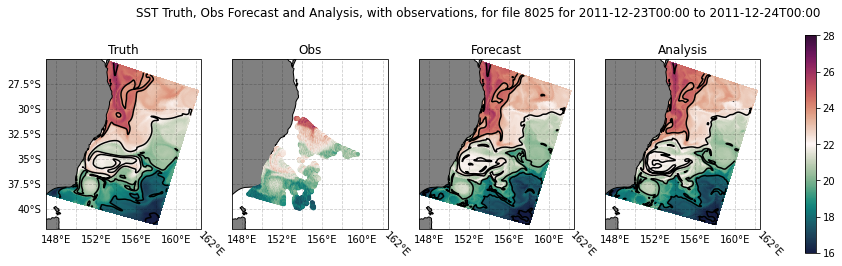

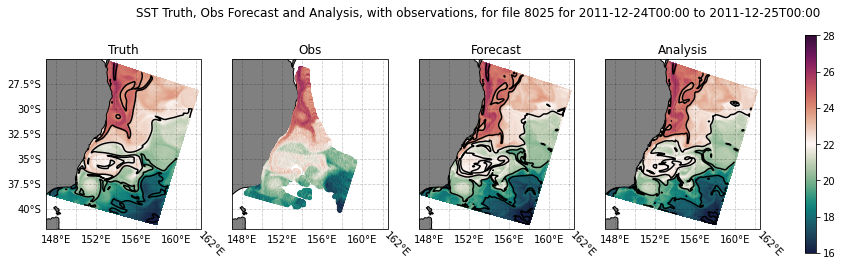

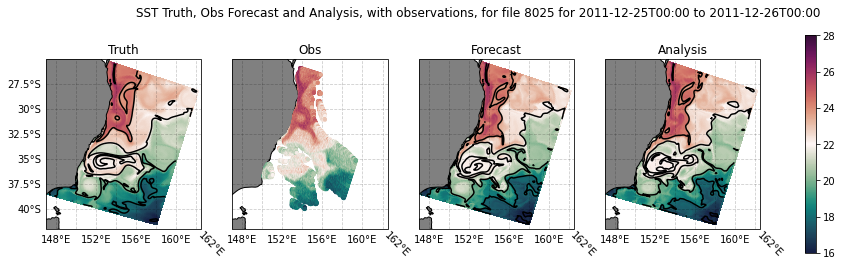

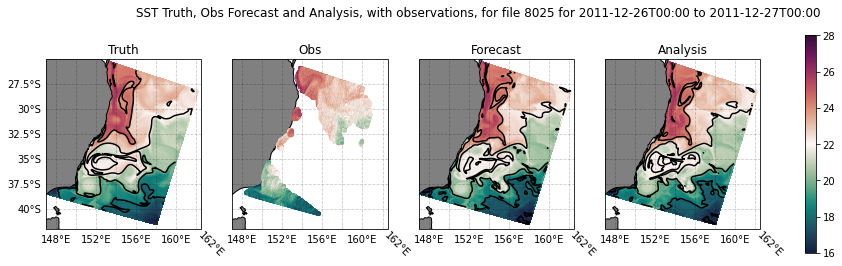

In [21]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=340

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    
    for tChunk in range(0,timeOutputMax,timeOutputs):
        fig, axes = plt.subplots(1,4, figsize=(16, 4), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[0]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([16,28])
        ax.set_title('Truth')
        
        ax = axes[1]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title('Obs')
        
        toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[2]            
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        im.set_clim([16,28])
        ax.set_title('Forecast')


        toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[3]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False  
        gl.left_labels = False
        im.set_clim([16,28])
        ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        fig.colorbar(im, ax=axes.ravel().tolist())
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Truth, Obs Forecast and Analysis, with observations, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')




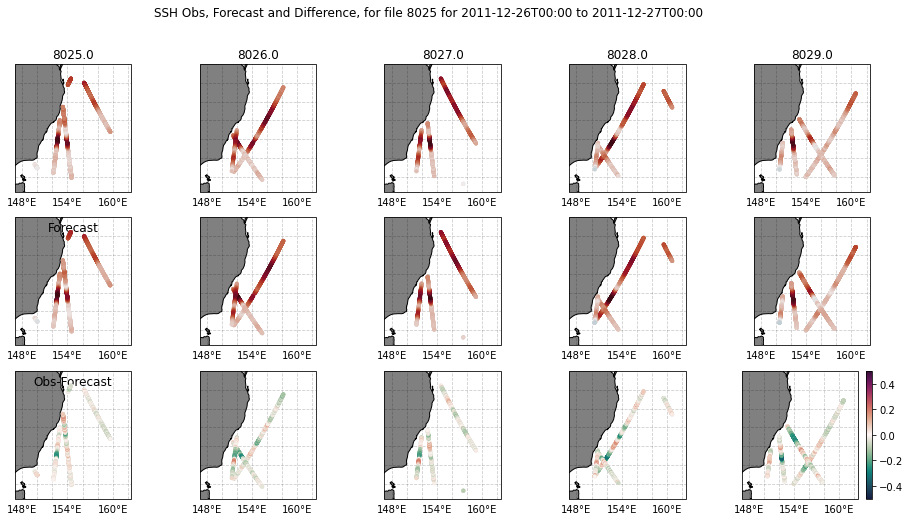

In [22]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=405

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-.5,.5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SSH Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('m')




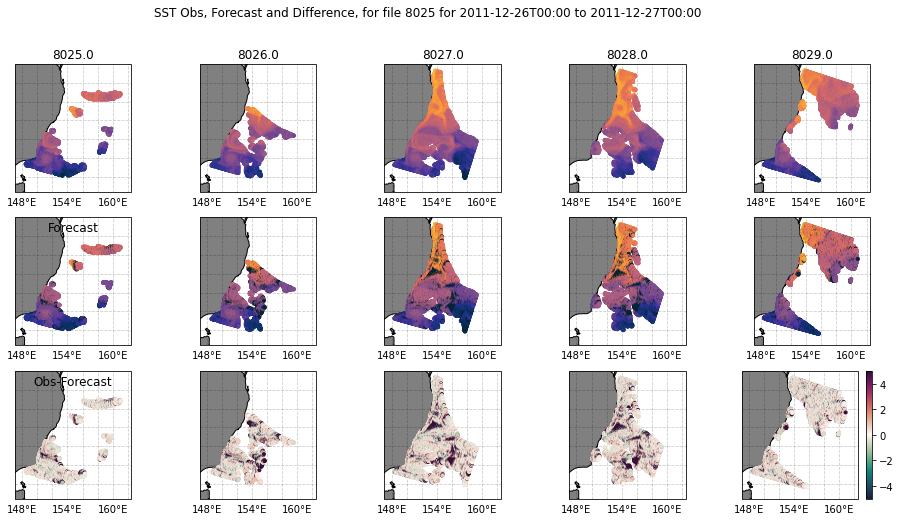

In [23]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    # sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    # sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-5,5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')




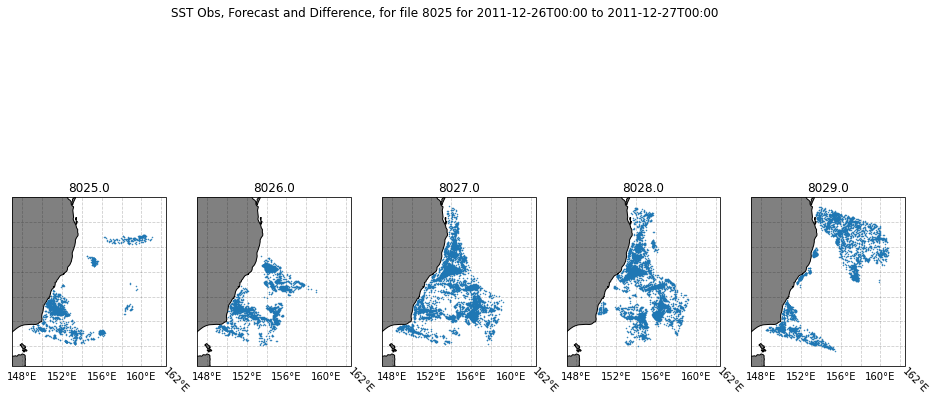

In [24]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(1,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        ax = axes[rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')

        lo=obs.obs_lon.where(obs.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==True).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==True).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        sc2 = ax.plot(lo,la,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)

        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        rr=rr+1
        
        #date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        #date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+str(time1)[:-13]+' to '+str(time2)[:-13])
        plt.ylabel('degC')




In [25]:
# mod.obs_value.where(np.isnan(mod.obs_scale)==False)
for dates in datelist:
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod = xr.open_dataset(filenameMod).load()
    print('file: '+str(dates)+'. Total number of obs: '+str(len(mod.obs_value))+'. Number of rejected obs: '+str(np.count_nonzero(np.isnan(mod.obs_scale)==True))+'. Percent rejected: '+str(np.round(np.count_nonzero(np.isnan(mod.obs_scale)==True)/np.count_nonzero(np.isnan(mod.obs_scale)==False)*100,decimals=1))+'%')


file: 8025. Total number of obs: 146824. Number of rejected obs: 18479. Percent rejected: 14.4%


In [26]:
str(dates)+'. Total number of obs: '+str(len(mod.obs_value))+'. Number of rejected obs: '+str(np.count_nonzero(np.isnan(mod.obs_scale)==True))+'. Percent rejected: '+str(np.round(np.count_nonzero(np.isnan(mod.obs_scale)==True)/np.count_nonzero(np.isnan(mod.obs_scale)==False)*100,decimals=1))+'%'

'8025. Total number of obs: 146824. Number of rejected obs: 18479. Percent rejected: 14.4%'

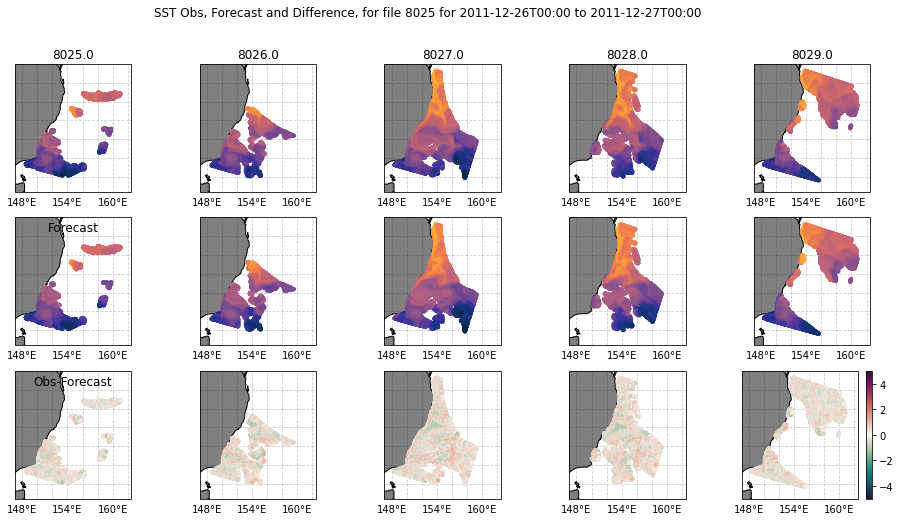

In [27]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    # sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    # sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-5,5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')


